In [1]:
import numpy as np
import pycbc.conversions as pc
import pycbc.pnutils as pnu
import pandas as pd
import h5py, os

from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random

import sys
from lal import YRJUL_SI

In [2]:
def save_dict_to_hdf5(dic, filename):
    """
    ....
    """
    with h5py.File(filename, 'w') as h5file:
        recursively_save_dict_contents_to_group(h5file, '/', dic)

def recursively_save_dict_contents_to_group(h5file, path, dic):
    """
    ....
    """
    for key, item in dic.items():
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
            h5file[path + key] = item
        elif isinstance(item, dict):
            recursively_save_dict_contents_to_group(h5file, path + key + '/', item)
        else:
            raise ValueError('Cannot save %s type'%type(item))

def load_dict_from_hdf5(filename):
    """
    ....
    """
    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/')

def recursively_load_dict_contents_from_group(h5file, path):
    """
    ....
    """
    ans = {}
    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            ans[key] = item[()]
        elif isinstance(item, h5py._hl.group.Group):
            ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/')
            
    return ans


def print_some_rcParams():
    rc_keys = ['backend', 'axes.labelsize', 'axes.titlesize', 'font.size',
        'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize', 'font.family',
        'text.usetex', 'figure.figsize'] # 'font.sans-serif', 'font.serif'
    print('Using the following matplotlib settings:')
    for k in rc_keys:
        print(k, ':', plt.rcParams[k])

In [3]:
ifar_threshold = 10 ## yr 

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)

In [5]:
#This is the first file, all events are true
injection_file = '/home/bhooshan.gadre/work/O3/sub_solar_search/O3B_VTs/ssm-search/O3b_VTs/common_ssm_injections.hdf'
injections = load_dict_from_hdf5(injection_file)
injections.keys(), len(injections.keys())

(dict_keys(['coa_phase', 'declination', 'distance', 'gstlal_ifar', 'gstlal_weight', 'inclination', 'mass1_source', 'mass2_source', 'mbta_ifar', 'polarization', 'pycbc_ifar', 'right_ascension', 'snr_H', 'snr_L', 'snr_V', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'time']),
 22)

In [6]:
df = pd.DataFrame(injections)
df

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time
0,1.463821,-1.232698,231.483117,0.0,0.666667,2.867627,1.692460,0.501600,0.0,2.515262,0.0,0.164688,2.440571,2.957571,1.361124,0.053696,0.053141,-0.037187,0.057080,-0.011039,0.007150,1.238166e+09
1,0.673478,-0.622410,458.599031,0.0,1.000000,0.918732,6.421466,0.763863,0.0,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09
2,5.447231,-1.440067,302.357273,0.0,0.666667,0.854144,10.481894,1.045793,0.0,0.132165,0.0,2.621765,4.408046,6.731172,1.315282,-0.004171,-0.046270,0.012784,0.021928,-0.027524,-0.030501,1.238166e+09
3,5.521864,-1.276307,463.341251,0.0,0.666667,0.494481,8.906005,0.811978,0.0,1.828451,0.0,3.177169,2.049177,3.539541,0.762279,0.000633,0.001265,-0.000504,0.004547,-0.011592,-0.004068,1.238166e+09
4,0.183151,-0.734805,833.927353,0.0,1.000000,2.895566,7.129897,0.808812,0.0,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916578,0.187059,-0.469964,752.284246,0.0,1.000000,0.388063,5.784159,0.559250,0.0,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09
1916579,0.141624,-0.272180,643.259480,0.0,0.666667,3.032152,8.621294,0.868851,0.0,0.817515,0.0,1.586071,2.718237,3.586084,3.759479,-0.007036,-0.019932,0.032837,-0.038478,0.020862,-0.010397,1.269562e+09
1916580,1.174031,-0.227858,349.130344,0.0,0.666667,2.206089,10.560706,0.717379,0.0,1.318691,0.0,3.475683,3.402718,2.469075,1.012893,0.004500,-0.054032,-0.029833,0.062644,0.023295,-0.031378,1.269562e+09
1916581,5.752044,0.708430,455.222188,0.0,1.000000,2.115026,5.727628,0.886952,0.0,1.553802,0.0,2.464774,2.854940,3.862371,0.634093,-0.028952,-0.016063,-0.024699,-0.048624,-0.022375,0.007844,1.269562e+09


In [7]:
# add chirpmass column and label
df['chirp_mass'] = ( (df['mass1_source'] * df['mass2_source'])**(3/5) ) / ( ( df['mass1_source'] + df['mass2_source'] )**(1/5) ) 
df

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time,chirp_mass
0,1.463821,-1.232698,231.483117,0.0,0.666667,2.867627,1.692460,0.501600,0.0,2.515262,0.0,0.164688,2.440571,2.957571,1.361124,0.053696,0.053141,-0.037187,0.057080,-0.011039,0.007150,1.238166e+09,0.774597
1,0.673478,-0.622410,458.599031,0.0,1.000000,0.918732,6.421466,0.763863,0.0,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09,1.750252
2,5.447231,-1.440067,302.357273,0.0,0.666667,0.854144,10.481894,1.045793,0.0,0.132165,0.0,2.621765,4.408046,6.731172,1.315282,-0.004171,-0.046270,0.012784,0.021928,-0.027524,-0.030501,1.238166e+09,2.579781
3,5.521864,-1.276307,463.341251,0.0,0.666667,0.494481,8.906005,0.811978,0.0,1.828451,0.0,3.177169,2.049177,3.539541,0.762279,0.000633,0.001265,-0.000504,0.004547,-0.011592,-0.004068,1.238166e+09,2.079797
4,0.183151,-0.734805,833.927353,0.0,1.000000,2.895566,7.129897,0.808812,0.0,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09,1.890638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916578,0.187059,-0.469964,752.284246,0.0,1.000000,0.388063,5.784159,0.559250,0.0,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09,1.397794
1916579,0.141624,-0.272180,643.259480,0.0,0.666667,3.032152,8.621294,0.868851,0.0,0.817515,0.0,1.586071,2.718237,3.586084,3.759479,-0.007036,-0.019932,0.032837,-0.038478,0.020862,-0.010397,1.269562e+09,2.134303
1916580,1.174031,-0.227858,349.130344,0.0,0.666667,2.206089,10.560706,0.717379,0.0,1.318691,0.0,3.475683,3.402718,2.469075,1.012893,0.004500,-0.054032,-0.029833,0.062644,0.023295,-0.031378,1.269562e+09,2.075954
1916581,5.752044,0.708430,455.222188,0.0,1.000000,2.115026,5.727628,0.886952,0.0,1.553802,0.0,2.464774,2.854940,3.862371,0.634093,-0.028952,-0.016063,-0.024699,-0.048624,-0.022375,0.007844,1.269562e+09,1.817291


In [8]:
df = df[df['gstlal_weight'] == 1.000000]
df

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time,chirp_mass
1,0.673478,-0.622410,458.599031,0.0,1.0,0.918732,6.421466,0.763863,0.000000e+00,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09,1.750252
4,0.183151,-0.734805,833.927353,0.0,1.0,2.895566,7.129897,0.808812,0.000000e+00,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09,1.890638
7,1.993550,-0.260465,488.862832,0.0,1.0,2.332464,8.636446,0.420814,0.000000e+00,0.206436,0.0,2.733766,3.672848,5.026132,0.952871,-0.031718,-0.045808,0.064866,0.000128,-0.000065,0.000301,1.238166e+09,1.395904
10,3.356570,-0.805484,433.718836,0.0,1.0,2.453931,10.508717,0.269122,0.000000e+00,2.014318,0.0,2.780945,2.717438,2.735633,1.377310,-0.048021,0.017748,0.034907,-0.002367,0.004690,-0.000318,1.238166e+09,1.159826
13,2.723905,-0.909426,410.483008,0.0,1.0,2.370470,3.218973,0.706197,1.130063e-09,1.393210,0.0,1.395882,4.397573,5.849438,0.762903,0.030845,0.010951,-0.028765,0.071988,-0.058108,-0.019227,1.238166e+09,1.245129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916569,5.536838,1.092579,496.300098,0.0,1.0,1.152792,8.155087,0.915510,0.000000e+00,2.368460,0.0,1.291601,3.169196,3.796076,1.034902,-0.013244,-0.001974,-0.028839,0.001049,0.021523,-0.076808,1.269561e+09,2.149452
1916572,4.042693,-0.601940,336.873980,0.0,1.0,2.181383,3.530335,0.956817,0.000000e+00,0.405525,0.0,4.728817,2.675803,3.185187,1.203063,0.001638,0.002812,0.002323,0.002218,0.013861,0.016641,1.269561e+09,1.537421
1916575,4.375681,-0.482808,571.785549,0.0,1.0,0.630822,7.595975,0.770182,0.000000e+00,1.279978,0.0,5.800984,3.672192,3.866309,0.186591,0.032819,0.002505,0.004759,0.004555,-0.059240,0.016644,1.269562e+09,1.887127
1916578,0.187059,-0.469964,752.284246,0.0,1.0,0.388063,5.784159,0.559250,0.000000e+00,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09,1.397794


In [9]:
df['gstlal_ifar'].describe()

count    8.578430e+05
mean     1.176488e+87
std      9.465599e+89
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.691170e+92
Name: gstlal_ifar, dtype: float64

In [10]:
df['mbta_ifar'].describe()

count    8.578430e+05
mean     1.675568e+13
std      1.195323e+16
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.104089e+19
Name: mbta_ifar, dtype: float64

In [11]:
df['pycbc_ifar'].describe()

count    857843.000000
mean        645.232398
std        5459.225126
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      142798.765113
Name: pycbc_ifar, dtype: float64

In [12]:
pd.options.mode.copy_on_write = True

df['label_gstlal_ifar']=np.where(df['gstlal_ifar']>10,1,0)
df['label_mbta_ifar']=np.where(df['mbta_ifar']>10,1,0)
df['label_pycbc_ifar']=np.where(df['pycbc_ifar']>10,1,0)

df

,coa_phase,declination,distance,gstlal_ifar,gstlal_weight,inclination,mass1_source,mass2_source,mbta_ifar,polarization,pycbc_ifar,right_ascension,snr_H,snr_L,snr_V,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,time,chirp_mass,label_gstlal_ifar,label_mbta_ifar,label_pycbc_ifar
1,0.673478,-0.622410,458.599031,0.0,1.0,0.918732,6.421466,0.763863,0.000000e+00,0.135494,0.0,2.177941,2.684150,2.988815,1.259368,-0.025080,-0.011637,0.021298,0.020269,0.071086,0.038439,1.238166e+09,1.750252,0,0,0
4,0.183151,-0.734805,833.927353,0.0,1.0,2.895566,7.129897,0.808812,0.000000e+00,2.805147,0.0,2.219308,2.389652,3.215351,0.549881,-0.051269,0.011986,-0.001127,-0.021172,0.014852,-0.003302,1.238166e+09,1.890638,0,0,0
7,1.993550,-0.260465,488.862832,0.0,1.0,2.332464,8.636446,0.420814,0.000000e+00,0.206436,0.0,2.733766,3.672848,5.026132,0.952871,-0.031718,-0.045808,0.064866,0.000128,-0.000065,0.000301,1.238166e+09,1.395904,0,0,0
10,3.356570,-0.805484,433.718836,0.0,1.0,2.453931,10.508717,0.269122,0.000000e+00,2.014318,0.0,2.780945,2.717438,2.735633,1.377310,-0.048021,0.017748,0.034907,-0.002367,0.004690,-0.000318,1.238166e+09,1.159826,0,0,0
13,2.723905,-0.909426,410.483008,0.0,1.0,2.370470,3.218973,0.706197,1.130063e-09,1.393210,0.0,1.395882,4.397573,5.849438,0.762903,0.030845,0.010951,-0.028765,0.071988,-0.058108,-0.019227,1.238166e+09,1.245129,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916569,5.536838,1.092579,496.300098,0.0,1.0,1.152792,8.155087,0.915510,0.000000e+00,2.368460,0.0,1.291601,3.169196,3.796076,1.034902,-0.013244,-0.001974,-0.028839,0.001049,0.021523,-0.076808,1.269561e+09,2.149452,0,0,0
1916572,4.042693,-0.601940,336.873980,0.0,1.0,2.181383,3.530335,0.956817,0.000000e+00,0.405525,0.0,4.728817,2.675803,3.185187,1.203063,0.001638,0.002812,0.002323,0.002218,0.013861,0.016641,1.269561e+09,1.537421,0,0,0
1916575,4.375681,-0.482808,571.785549,0.0,1.0,0.630822,7.595975,0.770182,0.000000e+00,1.279978,0.0,5.800984,3.672192,3.866309,0.186591,0.032819,0.002505,0.004759,0.004555,-0.059240,0.016644,1.269562e+09,1.887127,0,0,0
1916578,0.187059,-0.469964,752.284246,0.0,1.0,0.388063,5.784159,0.559250,0.000000e+00,3.122078,0.0,4.757083,2.959844,2.958614,0.812961,-0.032232,0.036856,-0.038265,-0.001476,0.035159,-0.032295,1.269562e+09,1.397794,0,0,0


In [13]:
df[df['label_mbta_ifar']==0].describe().T

,count,mean,std,min,25%,50%,75%,max
coa_phase,830096.0,3.139112e+00,1.813756e+00,6.599469e-07,1.567626e+00,3.140039e+00,4.709343e+00,6.283179e+00
declination,830096.0,-7.609090e-04,6.989857e-01,-1.564606e+00,-5.540113e-01,-4.859542e-04,5.518396e-01,1.570080e+00
distance,830096.0,3.890793e+02,1.959914e+02,4.824868e+00,2.394653e+02,3.568218e+02,5.092767e+02,1.009410e+03
gstlal_ifar,830096.0,1.215710e+87,9.622498e+89,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.691170e+92
gstlal_weight,830096.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
inclination,830096.0,1.571723e+00,9.444893e-01,5.959355e-05,6.582395e-01,1.575726e+00,2.486034e+00,3.140828e+00
mass1_source,830096.0,5.643997e+00,2.911127e+00,1.958331e-01,3.142483e+00,5.508060e+00,8.100511e+00,1.099997e+01
mass2_source,830096.0,6.856072e-01,2.535937e-01,1.900007e-01,4.774093e-01,7.014473e-01,9.044962e-01,1.100000e+00
mbta_ifar,830096.0,1.494495e-02,2.678287e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.996874e+00
polarization,830096.0,1.570004e+00,9.064142e-01,1.155127e-06,7.845843e-01,1.570175e+00,2.354627e+00,3.141585e+00


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [15]:
df['combined_label'] = np.where(
    (df[['label_pycbc_ifar', 'label_mbta_ifar', 'label_gstlal_ifar']].values == 1).all(axis=1), 
    1, 
    0
)

In [16]:
X = df.drop(columns=['label_pycbc_ifar', 'label_mbta_ifar', 'label_gstlal_ifar', 'combined_label'])
y = df['combined_label']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [20]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
# Calculate performance metrics
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

In [29]:
# Calculate the percentage of true positives
total_test_samples = len(y_test)
tp_percentage_over_test = (tp / total_test_samples) * 100
tp_percentage_over_test_positive = (tp / y_test.value_counts()[1]) * 100
tn_percentage_over_test_negative = (tn / y_test.value_counts()[0]) * 100

In [30]:
# Store results in dictionary
results = {
    'model': model,
    'roc_auc': roc_auc,
    'accuracy': accuracy,
    'report': classification_report(y_test, y_pred, output_dict=True),
    'confusion_matrix': {
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp
    },
    'tp_percentage_over_test': tp_percentage_over_test,
    'tp_percentage_over_test_positive': tp_percentage_over_test_positive
    }

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    168920
           1       0.63      0.27      0.38      2649

    accuracy                           0.99    171569
   macro avg       0.81      0.64      0.69    171569
weighted avg       0.98      0.99      0.98    171569

Confusion Matrix for Logistic Regression:
True Negatives: 168498
False Positives: 422
False Negatives: 1925
True Positives: 724
Number of True Positives in y_test: 2649
Percentage of True Positives over Test Set: 0.42%
Percentage of True Positives over Test Set Positives: 27.33%
Percentage of True Negatives over Test Set Negatives: 99.75%
ROC-AUC Score: 0.635406229632671
Accuracy: 0.9863203725614768




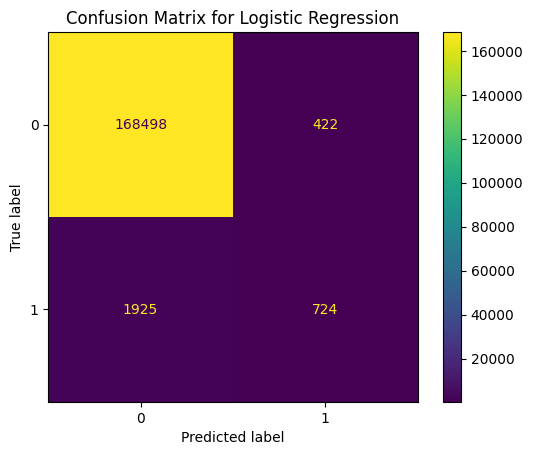

In [32]:
# Print the results
print(f"Results for Logistic Regression:")
print(classification_report(y_test, y_pred))
print(f"Confusion Matrix for Logistic Regression:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Number of True Positives in y_test: {y_test.value_counts()[1]}")
print(f"Percentage of True Positives over Test Set: {tp_percentage_over_test:.2f}%")
print(f"Percentage of True Positives over Test Set Positives: {tp_percentage_over_test_positive:.2f}%")
print(f"Percentage of True Negatives over Test Set Negatives: {tn_percentage_over_test_negative:.2f}%")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}")
print("\n")

# Show Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [33]:
168498+422+1925+724

171569

In [34]:
724/171569

0.004219876551125204

In [35]:
y_test.value_counts()[1]

2649

In [36]:
724/2649

0.2733106832767082